In [7]:
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
dow_jones_tickers = si.tickers_dow()
print(dow_jones_tickers)


URLError: <urlopen error [WinError 10053] 你的主机中的软件中止了一个已建立的连接。>

In [6]:
dow_jones_tickers

NameError: name 'dow_jones_tickers' is not defined

In [ ]:
data_table=[]
for ticker in dow_jones_tickers:
    data_table.append(si.get_data(ticker,'2021-08-20')['close'].values)
arr = np.array(data_table).transpose()
df = pd.DataFrame(arr, columns = dow_jones_tickers)
df.head()

NameError: name 'dow_jones_tickers' is not defined

In [ ]:
dow_divisor=0.1517275
price_data=df.to_numpy()
dow_index=(np.sum(price_data,axis=1)/dow_divisor)

NameError: name 'df' is not defined

In [ ]:
g = sns.relplot(x=range(0,len(dow_index)),y=dow_index, kind="line")

NameError: name 'dow_index' is not defined

In [ ]:
risk_free_rate=0.0288

In [ ]:
def sharpe_ratio_calc(data,risk_free_rate):
    sharpe_ratio=((data[-1]-data[0])/data[0]-risk_free_rate)/np.std((data[1:]-data[0:-1])/data[0:-1])
    return sharpe_ratio

In [ ]:
print(sharpe_ratio_calc(dow_index,risk_free_rate))

-6.400758671866319


In [ ]:
def price_adjustment(price_data,new_weight):
    total_capital=np.sum(price_data[0,:])
    new_weight[new_weight<0]=0.001
    new_weight=new_weight/sum(new_weight)
    adjusted_price=price_data*(new_weight*total_capital/price_data[0,:])
    price=(np.sum(adjusted_price,axis=1)/dow_divisor)
    return price, new_weight


In [ ]:
def evaluate(price_data,new_weight):
    price,w=price_adjustment(price_data,new_weight)
    return sharpe_ratio_calc(price,risk_free_rate)

In [ ]:
def selection(weight,score,population):
    return weight[np.argsort(score)[int(population/2):],:]

In [ ]:
def crossover(new_parents):
    pairs=np.split(new_parents,2)
    children=np.zeros(new_parents.shape)
    counter=0

    for i in range(pairs[0].shape[0]):
        position=np.random.choice(pairs[0].shape[1], int(pairs[0].shape[1]/2))
        p1=pairs[0][i]
        p2=pairs[1][i]
        children[counter,:]=p1
        children[counter,position]=p2[position]
        counter+=1
        children[counter,:]=p2
        children[counter,position]=p1[position]
        counter+=1
    
    return children

In [ ]:
def mutation(children):
    mutation_rate=0.5
    for i in range(children.shape[0]):
        for j in range(children.shape[1]):
            if np.random.rand()>mutation_rate:
                children[i,j]=children[i,j]*(1+np.random.randint(-1000,1000)/10000)
    return children

In [ ]:
population=100
new_population=np.random.rand(population,30)
sharpe_ratio=np.zeros((population))
num_gen=100
for k in range(num_gen):
    for i in range(population):
        sharpe_ratio[i]=evaluate(price_data,new_population[i,:])

    new_parents=selection(new_population,sharpe_ratio,population)
    children=crossover(new_parents)
    children=mutation(children)
    new_population=np.vstack((new_parents,children))
    

for i in range(population):
    sharpe_ratio[i]=evaluate(price_data,new_population[i,:])

index=np.argmax(sharpe_ratio)
new_weight=new_population[index,:]
new_price,percentage=price_adjustment(price_data,new_weight)

In [ ]:
print(sharpe_ratio[index])
print(percentage)

32.2116494062456
[1.80586813e-02 1.54278784e-02 4.61144264e-05 2.77259033e-03
 1.73315916e-03 6.12859911e-04 2.38637409e-03 7.88614196e-01
 4.83786519e-04 2.06667913e-03 1.06296022e-03 5.68543371e-03
 5.22424743e-04 7.42264643e-03 1.86204944e-03 5.81290552e-04
 1.68257760e-03 1.89898680e-02 1.59174550e-02 1.28180076e-03
 2.29298417e-02 4.59115870e-03 8.17804781e-04 2.47336409e-03
 6.49446315e-04 7.76835720e-02 2.78038847e-04 2.33237621e-03
 5.36387551e-04 4.97183770e-04]


In [ ]:
#没有优化的收益
print((dow_index[-1]-dow_index[0])/dow_index[0]*100)
#优化后的收益
print((new_price[-1]-new_price[0])/new_price[0]*100)


-4.013854780283731
56.08752022686028


<AxesSubplot:>

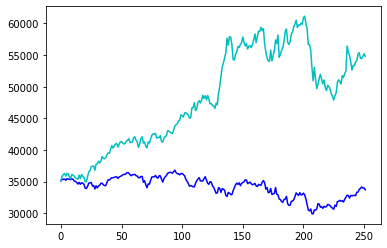

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=range(0,len(dow_index)),y=dow_index,color='b')
sns.lineplot(x=range(0,len(dow_index)),y=new_price,color='c')